# Logic Gate Task

This task utilizes a simple neural network containing single n-task context layer to learn eight different logic gates.

**Note:** This experiment uses a variation of the traditional n-task model to incorporate learning between batches instead of applying gradients at the end of batches. The idea is that learning will be much faster and more stable while retaining the ability to switch on bad contexts.

In [1]:
%load_ext autoreload

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense

import datetime
import numpy as np
import os

import matplotlib.pyplot as plt

# Import n-task
from ntask.atrs import AtrMovingAverage
from ntask.callbacks import AtrLogger
from ntask.flags import Verbosity
from ntask.layers import Context
from ntask.models import NTaskModel
from ntask.training import train, evaluate
from ntask.utils import set_seed

___

## Experimentation Setup

The following cells here build everything up for the experiments to execute

### Dataset Creation

The following cell creates the base dataset with all of the gates.

In [3]:
# Define the gates explicitly
gates = {
    "xor":      [0, 1, 1, 0],
    "xnor":     [1, 0, 0, 1],
    "and":      [0, 0, 0, 1],
    "or":       [0, 1, 1, 1],
    "nor":      [1, 0, 0, 0],
    "nand":     [1, 1, 1, 0],
    "custom_1": [1, 0, 1, 0],
    "custom_2": [0, 1, 0, 1]
}

# Build the labels used for `y_train` to work with the `train` convenience function
y_labels = [np.array([[i] for i in gate]) for gate in gates.values()]

# The inputs for each of the gates
x_train = np.array([[-1, -1], [-1, 1], [1, -1], [1, 1]])

### Model Architecture and Creation

The following function creates a new instance of the model for each experiment. The hyperparameters are provided as arguments. The model summary is also displayed.

In [4]:
def create_model(tag, optimizer, num_contexts, max_contexts=0, switch_threshold=0.0, add_threshold=0.0, summary=True):
    # Model architecture
    inp = Input((2,))
    x = Dense(hrr_size, activation="relu")(inp)
    x = Context(
        num_contexts,
        AtrMovingAverage(max_contexts=max_contexts, switch_threshold=switch_threshold, add_threshold=add_threshold),
        name="Gate_Context"
    )(x)
    x = Dense(1, activation="sigmoid")(x)
    model = NTaskModel(inputs=inp, outputs=x)
    
    # Compile the model together with binary_crossentropy loss
    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(),
        optimizer=optimizer,
        metrics=[
            tf.keras.metrics.BinaryAccuracy()
        ]
    )
    
    # Display the model summary
    if summary:
        model.summary()
    
    return model

___

## Experimentation

### Static n-task: (XOR, XNOR)

The following experiments demonstrates the model successfully learning two separate logic gates.

In [15]:
TAG = "static-2-gate"

#### Dataset

In [16]:
y_train = y_labels[:2]

#### Seeding

In [17]:
set_seed(5)

#### Model Creation

In [18]:
# Optimizer
optimizer = tf.keras.optimizers.SGD(1e-1)

# Hyperparameters
hrr_size         = 128
num_contexts     = len(y_train)
switch_threshold = -0.02

# Create the model
model = create_model(TAG, optimizer, num_contexts=len(y_train), switch_threshold=switch_threshold)

Model: "n_task_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               384       
_________________________________________________________________
Gate_Context (Context)       (None, 128)               260       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 773
Trainable params: 513
Non-trainable params: 260
_________________________________________________________________


#### Training

In [19]:
cycles     = 3
epochs     = 10
batch_size = 1

shuffle              = True  # Shuffle the active context dataset during training
task_shuffle         = True  # Shuffle the contexts during training after first epoch
initial_task_shuffle = True  # Shuffle the contexts before training

verbose = Verbosity.Contexts

logger = AtrLogger()
callbacks = [logger]

# Train the model
%time task_map, context_map = train(model, x_train, y_train, cycles, epochs, task_shuffle, initial_task_shuffle, batch_size=batch_size, shuffle=shuffle, callbacks=callbacks, verbose=verbose)


[Gate_Context] Switched context to 1

[Gate_Context] Switched context to 0

[Gate_Context] Switched context to 1

[Gate_Context] Switched context to 0
CPU times: user 1.02 s, sys: 109 ms, total: 1.12 s
Wall time: 961 ms


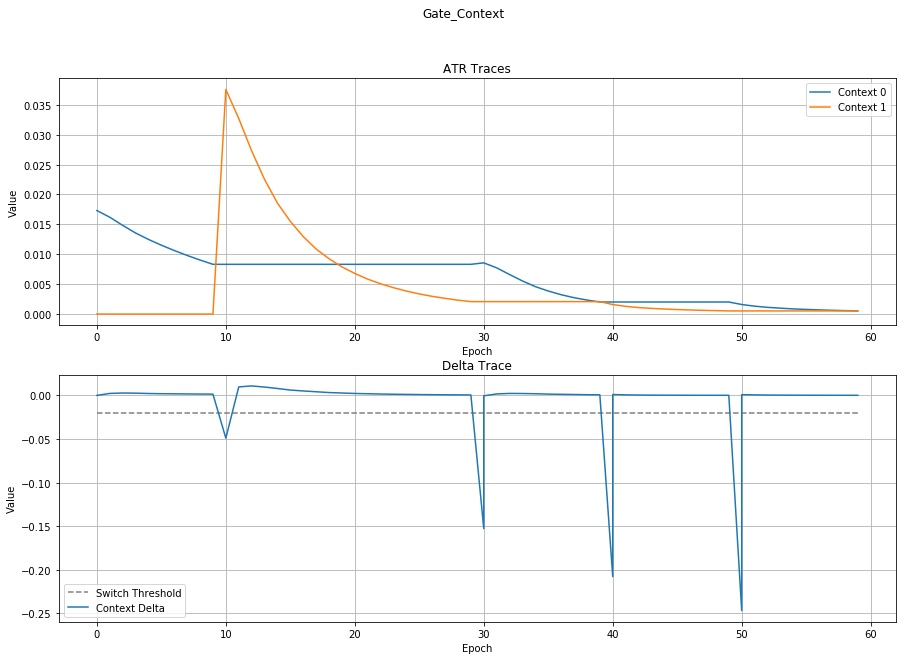

In [20]:
logger.plot(figsize=(15,10))

#### Evaluation

In [21]:
batch_size = 1
display_predictions = True
verbose = 0

%time evaluate(model, x_train, y_train, task_map, context_map, display_predictions, batch_size=batch_size, verbose=verbose)

array([[0.04025948],
       [0.96960604],
       [0.96226275],
       [0.03171104]], dtype=float32)
array([[0.97145987],
       [0.02444988],
       [0.03115296],
       [0.9637778 ]], dtype=float32)
CPU times: user 312 ms, sys: 15.6 ms, total: 328 ms
Wall time: 318 ms


[{'loss': 0.03566252812743187, 'binary_accuracy': 1.0},
 {'loss': 0.030563028529286385, 'binary_accuracy': 1.0}]

___

### Dynamic n-task: (XOR, XNOR)

The following experiments demonstrates the model successfully learning two separate logic gates dynamically adding contexts to the layers.

In [22]:
TAG = "dynamic-2-gate"

#### Dataset

In [23]:
y_train = y_labels[:2]

#### Seeding

In [24]:
set_seed(5)

#### Model Creation

In [25]:
# Optimizer
optimizer = tf.keras.optimizers.SGD(1e-1)

# Hyperparameters
hrr_size         = 128
num_contexts     = 1
max_contexts     = len(y_train)
switch_threshold = -0.02
add_threshold    = -0.04

# Create the model
model = create_model(TAG, optimizer, num_contexts=num_contexts, max_contexts=max_contexts, switch_threshold=switch_threshold, add_threshold=add_threshold)

Model: "n_task_model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               384       
_________________________________________________________________
Gate_Context (Context)       (None, 128)               260       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 773
Trainable params: 513
Non-trainable params: 260
_________________________________________________________________


#### Training

In [26]:
cycles     = 3
epochs     = 10
batch_size = 1

shuffle              = True  # Shuffle the active context dataset during training
task_shuffle         = True  # Shuffle the contexts during training after first epoch
initial_task_shuffle = True  # Shuffle the contexts before training

verbose = Verbosity.Contexts

logger = AtrLogger()
callbacks = [logger]

# Benchmark the model
%time task_map, context_map = train(model, x_train, y_train, cycles, epochs, task_shuffle, initial_task_shuffle, batch_size=batch_size, shuffle=shuffle, callbacks=callbacks, verbose=verbose)


[Gate_Context] Adding context 1

[Gate_Context] Switched context to 1

[Gate_Context] Switched context to 0

[Gate_Context] Switched context to 1

[Gate_Context] Switched context to 0
CPU times: user 1.02 s, sys: 188 ms, total: 1.2 s
Wall time: 983 ms


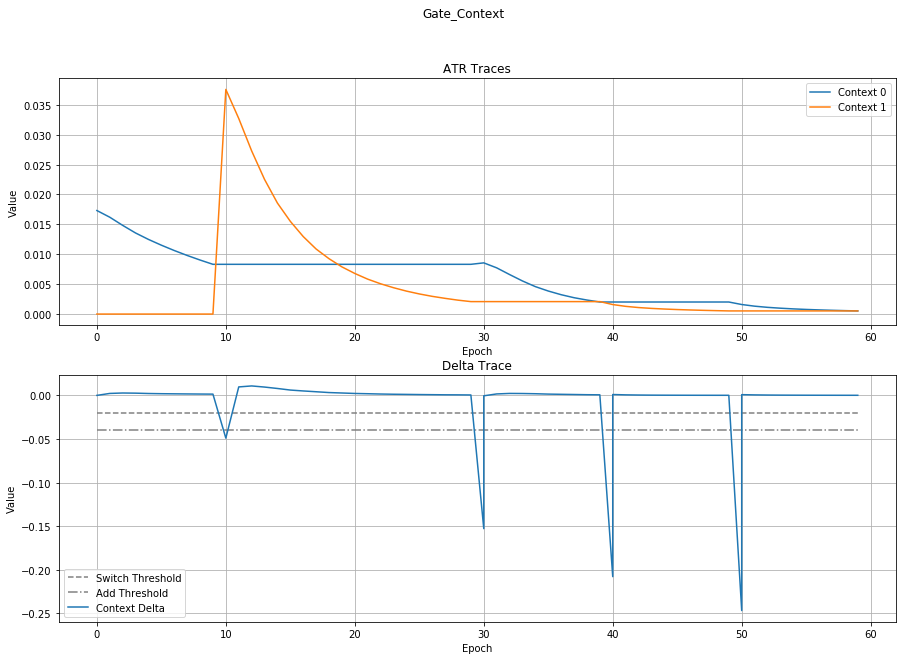

In [27]:
logger.plot(figsize=(15,10))

#### Evaluation

In [28]:
batch_size = 1
display_predictions = True
verbose = 0

%time evaluate(model, x_train, y_train, task_map, context_map, display_predictions, batch_size=batch_size, verbose=verbose)

array([[0.04025948],
       [0.96960604],
       [0.96226275],
       [0.03171104]], dtype=float32)
array([[0.97145987],
       [0.02444988],
       [0.03115296],
       [0.9637778 ]], dtype=float32)
CPU times: user 297 ms, sys: 0 ns, total: 297 ms
Wall time: 297 ms


[{'loss': 0.03566252812743187, 'binary_accuracy': 1.0},
 {'loss': 0.030563028529286385, 'binary_accuracy': 1.0}]

___

### Static n-task: All Gates

The following experiments demonstrates the model successfully learning two separate logic gates dynamically adding contexts to the layers.

In [29]:
TAG = "static-all-gates"

#### Dataset

In [30]:
y_train = y_labels[:]

#### Seeding

In [31]:
set_seed(5)

#### Model Creation

In [32]:
# Optimizer
optimizer = tf.keras.optimizers.SGD(1e-1)

# Hyperparameters
hrr_size         = 128
num_contexts     = len(y_train)
switch_threshold = -0.02

# Create the model
model = create_model(TAG, optimizer, num_contexts=num_contexts, switch_threshold=switch_threshold)

Model: "n_task_model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               384       
_________________________________________________________________
Gate_Context (Context)       (None, 128)               1034      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 1,547
Trainable params: 513
Non-trainable params: 1,034
_________________________________________________________________


#### Training

In [33]:
cycles     = 3
epochs     = 10
batch_size = 1

shuffle              = True  # Shuffle the active context dataset during training
task_shuffle         = True  # Shuffle the contexts during training after first epoch
initial_task_shuffle = True  # Shuffle the contexts before training

verbose = 0 # Verbosity.Contexts

logger = AtrLogger()
callbacks = [logger]

# Benchmark the model
%time task_map, context_map = train(model, x_train, y_train, cycles, epochs, task_shuffle, initial_task_shuffle, batch_size=batch_size, shuffle=shuffle, callbacks=callbacks, verbose=verbose)

CPU times: user 3.98 s, sys: 391 ms, total: 4.38 s
Wall time: 3.67 s


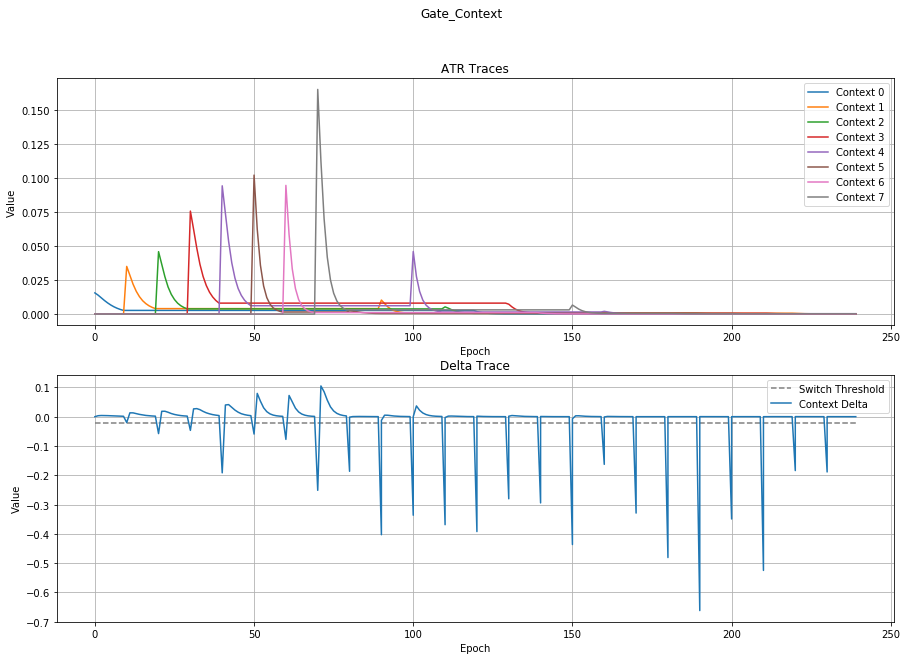

In [34]:
logger.plot(figsize=(15,10))

#### Evaluation

In [35]:
batch_size = 1
display_predictions = True
verbose = 0

%time evaluate(model, x_train, y_train, task_map, context_map, display_predictions, batch_size=batch_size, verbose=verbose)

array([[0.00593275],
       [0.98893386],
       [0.9847105 ],
       [0.02813032]], dtype=float32)
array([[0.98548245],
       [0.01487198],
       [0.01345024],
       [0.9954912 ]], dtype=float32)
array([[0.00240618],
       [0.00584942],
       [0.00997534],
       [0.9820519 ]], dtype=float32)
array([[0.01358461],
       [0.98393106],
       [0.9841983 ],
       [0.9930084 ]], dtype=float32)
array([[0.98782384],
       [0.01603228],
       [0.01002574],
       [0.0028097 ]], dtype=float32)
array([[0.9954127 ],
       [0.9846736 ],
       [0.9950181 ],
       [0.00408122]], dtype=float32)
array([[0.9973501 ],
       [0.00511506],
       [0.9934953 ],
       [0.00752574]], dtype=float32)
array([[0.00310922],
       [0.99892855],
       [0.01164132],
       [0.9962133 ]], dtype=float32)
CPU times: user 422 ms, sys: 46.9 ms, total: 469 ms
Wall time: 433 ms


[{'loss': 0.015254860743880272, 'binary_accuracy': 1.0},
 {'loss': 0.011917021125555038, 'binary_accuracy': 1.0},
 {'loss': 0.009103082120418549, 'binary_accuracy': 1.0},
 {'loss': 0.01320531964302063, 'binary_accuracy': 1.0},
 {'loss': 0.01032579317688942, 'binary_accuracy': 1.0},
 {'loss': 0.00728169921785593, 'binary_accuracy': 1.0},
 {'loss': 0.005465449765324593, 'binary_accuracy': 1.0},
 {'loss': 0.004922402091324329, 'binary_accuracy': 1.0}]

___

### Dynamic n-task: All Gates

The following experiments demonstrates the model successfully learning two separate logic gates dynamically adding contexts to the layers.

**NOTE:** The results to this task require some further analysis. I'm not certain what exactly the spikes really mean here, especially since they're displaying positive context-loss deltas. Also the fact that the first few tasks are initially learned using the very first context, and only later are things learned in their appropriate contexts.

In [83]:
TAG = "dynamic-all-gates"

#### Dataset

In [84]:
y_train = y_labels[:]

#### Seeding

In [85]:
set_seed(5)

#### Model Creation

In [86]:
# Optimizer
optimizer = tf.keras.optimizers.SGD(1e-1)

# Hyperparameters
hrr_size         = 128
num_contexts     = 1
max_contexts     = len(y_train)
switch_threshold = -0.02
add_threshold    = -0.08

# Create the model
model = create_model(TAG, optimizer, num_contexts=num_contexts, max_contexts=max_contexts, switch_threshold=switch_threshold, add_threshold=add_threshold)

Model: "n_task_model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 2)]               0         
_________________________________________________________________
dense_26 (Dense)             (None, 128)               384       
_________________________________________________________________
Gate_Context (Context)       (None, 128)               1034      
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 129       
Total params: 1,547
Trainable params: 513
Non-trainable params: 1,034
_________________________________________________________________


#### Training

In [87]:
cycles     = 3
epochs     = 20
batch_size = 1

shuffle              = True  # Shuffle the active context dataset during training
task_shuffle         = True  # Shuffle the contexts during training after first epoch
initial_task_shuffle = True  # Shuffle the contexts before training

# verbose = Verbosity.Contexts
verbose = 0

logger = AtrLogger()
callbacks = [logger]

# Benchmark the model
%time task_map, context_map = train(model, x_train, y_train, cycles, epochs, task_shuffle, initial_task_shuffle, batch_size=batch_size, shuffle=shuffle, callbacks=callbacks, verbose=verbose)

CPU times: user 6.58 s, sys: 719 ms, total: 7.3 s
Wall time: 5.91 s


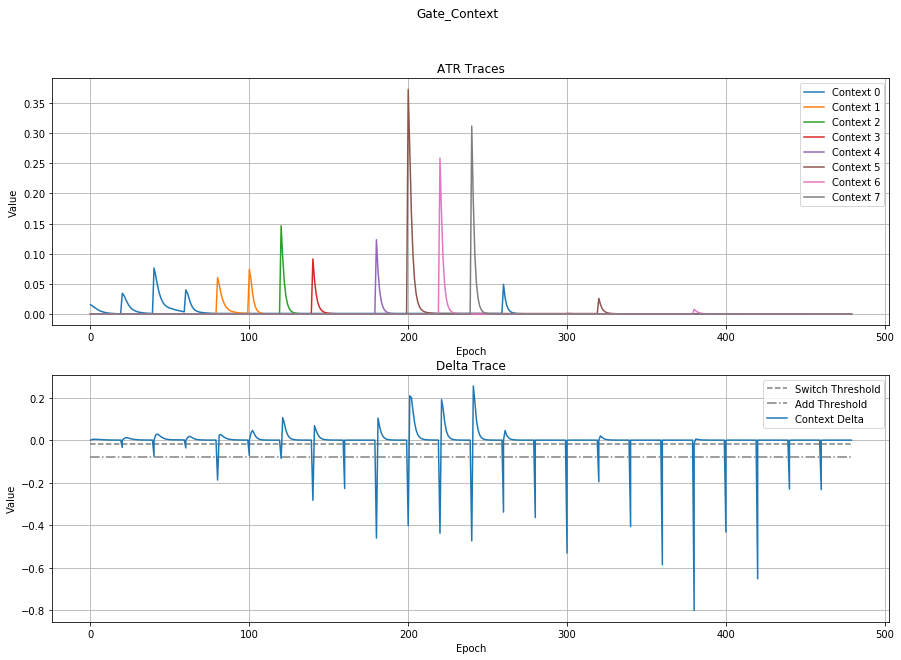

In [88]:
logger.plot(figsize=(15,10))

#### Evaluation

In [89]:
batch_size = 1
display_predictions = True
verbose = 0

%time evaluate(model, x_train, y_train, task_map, context_map, display_predictions, batch_size=batch_size, verbose=verbose)

array([[0.00723264],
       [0.93782854],
       [0.9498591 ],
       [0.00287011]], dtype=float32)
array([[0.98832023],
       [0.00237024],
       [0.00483271],
       [0.9900248 ]], dtype=float32)
array([[0.00279853],
       [0.00724164],
       [0.0018844 ],
       [0.99935496]], dtype=float32)
array([[0.00274053],
       [0.9950144 ],
       [0.9936186 ],
       [0.9973394 ]], dtype=float32)
array([[0.98737764],
       [0.0090552 ],
       [0.00753856],
       [0.00226769]], dtype=float32)
array([[0.99796695],
       [0.98994803],
       [0.9983245 ],
       [0.00225127]], dtype=float32)
array([[9.9932086e-01],
       [1.1155049e-04],
       [9.9751312e-01],
       [2.8488040e-04]], dtype=float32)
array([[0.00635347],
       [0.9942765 ],
       [0.0063881 ],
       [0.9984864 ]], dtype=float32)
CPU times: user 531 ms, sys: 62.5 ms, total: 594 ms
Wall time: 541 ms


[{'loss': 0.03144076094031334, 'binary_accuracy': 1.0},
 {'loss': 0.007247830741107464, 'binary_accuracy': 1.0},
 {'loss': 0.0031504775397479534, 'binary_accuracy': 1.0},
 {'loss': 0.004202056210488081, 'binary_accuracy': 1.0},
 {'loss': 0.007909111678600311, 'binary_accuracy': 1.0},
 {'loss': 0.004017171915620565, 'binary_accuracy': 1.0},
 {'loss': 0.0008914335048757493, 'binary_accuracy': 1.0},
 {'loss': 0.00500924326479435, 'binary_accuracy': 1.0}]